In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# np.random.seed(9630)

# Things to do

* Remember to Normalize your data and create validation split from train set.
* Learn about tf.data, tf.slices and also tf.records

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_val = x_train[50000:60000]
x_train = x_train[0:50000]
y_val = y_train[50000:60000]
y_train = y_train[0:50000]
x_train = x_train.astype(np.float32).reshape(-1,28,28,1) / 255.0
x_val = x_val.astype(np.float32).reshape(-1,28,28,1) / 255.0
x_test = x_test.astype(np.float32).reshape(-1,28,28,1) / 255.0
y_train = tf.one_hot(y_train, depth=10)
y_val = tf.one_hot(y_val, depth=10)
y_test = tf.one_hot(y_test, depth=10)
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(128)
train_dataset_full = train_dataset.shuffle(buffer_size=1024).batch(len(train_dataset))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(128)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(128)
print(len(train_dataset))
print(len(test_dataset))

(50000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)
391
10000


# Create your custom CNN class

* Convolution layers has 4D weights of size (h,w,input_feature, output_feature), where h=height of your kernel and w = width of our kernel. If you add batches then it is 5D.
* Now your model will convolve across your input feature map with kernel and create output feature map, that is then passed to next layer.
* As we have learned in our prior class, to initialize your weights, we use tf.Variable(weight_init(size)), tf.keras.layers.Conv2D will do this for you. Play with the function and see how it works for your problem.
* Few important concepts, learn to save your model after every k epochs and start re-training from last checkpoint. This is very useful, and you don't need to retrain your model from scratch.

In [ ]:
# Batch Normalization for CNN

class BNLayer(tf.keras.layers.Layer):
    def __init__(self, dim, epsilon=10e-8, momentum=0.99):
        super(BNLayer, self).__init__()

        self.epsilon = epsilon
        self.momentum = momentum
        self.dim = dim

        self.it_call = 0
        self.batch_size = 0

        self.mu = self.add_weight("mu", shape=[self.dim,], 
                                initializer="zeros",
                                trainable=False)
        self.var = self.add_weight("var", shape=[self.dim,], 
                                   initializer="zeros",
                                   trainable=False)

        self.gamma = self.add_weight("gamma", shape=[1, self.dim],
                                     initializer="random_normal",
                                     trainable=True)
        self.beta = self.add_weight("beta", shape=[1, self.dim],
                                    initializer="random_normal",
                                    trainable=True)
        
    
    def call(self, inputs, is_training=True):
        """forward
        BN(x) = gamma * ((x - mu) / sqrt(var + epsilon)) + beta
        """

        if is_training:   # is_training == True: compute BN 
            if self.batch_size == 0:
                self.batch_size = inputs.shape[0]
            
            batch_mu = tf.math.reduce_mean(inputs, axis=(0,1,2))
            batch_var = tf.math.reduce_variance(inputs, axis=(0,1,2))
            
            normalized_inputs = tf.math.divide((inputs - batch_mu), tf.math.sqrt(batch_var + self.epsilon))
            bn_inputs = tf.math.multiply(self.gamma, normalized_inputs) + self.beta

            # update mu and var
            if inputs.shape[0] == self.batch_size:
                running_mu = batch_mu
                running_var = batch_var
            else:
                # the last batch in training may have sample less than batch size
                running_mu = batch_mu / inputs.shape[0] * self.batch_size
                running_var = batch_var / inputs.shape[0] * self.batch_size
            
            cur_mu = running_mu * (self.momentum) + self.mu * (1 - (self.momentum))
            self.mu.assign(cur_mu)
            cur_var = running_var * (self.momentum) + self.var * (1 - (self.momentum))
            self.var.assign(cur_var)


        else: # is_training == False
            normalized_inputs = tf.math.divide((inputs - self.mu), tf.math.sqrt(self.var + self.epsilon))
            bn_inputs = tf.math.multiply(self.gamma, normalized_inputs) + self.beta
        
        return bn_inputs

In [ ]:
class ImageRecognitionCNN(tf.keras.Model):
    
    def __init__(self, num_classes, device='cpu:0', checkpoint_directory=None):
        ''' Define the parameterized layers used during forward-pass, the device
            where you would like to run the computation (GPU, TPU, CPU) on and the checkpoint
            directory.
            
            Args:
                num_classes: the number of labels in the network.
                device: string, 'cpu:n' or 'gpu:n' (n can vary). Default, 'cpu:0'.
                checkpoint_directory: the directory where you would like to save or 
                                      restore a model.
        ''' 
        super(ImageRecognitionCNN, self).__init__()
        
        # Initialize layers
        self.conv1 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        self.conv2 = tf.keras.layers.Conv2D(64, 3,padding='same', activation=None)
        self.pool1 = tf.keras.layers.MaxPool2D()
        self.conv3 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        self.conv4 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        # self.pool2 = tf.keras.layers.MaxPool2D()
        # self.conv5 = tf.keras.layers.Conv2D(64, 3, padding='same', activation=None)
        # self.pool2 = tf.keras.layers.MaxPool2D()
        # self.conv6 = tf.keras.layers.Conv2D(64, 3, 2, padding='same', activation=None)
        # self.conv7 = tf.keras.layers.Conv2D(64, 1, padding='same', activation=None)
        self.conv8 = tf.keras.layers.Conv2D(num_classes, 1, padding='same', activation=None)
        self.bn = BNLayer(64)
        
        # Define the device 
        self.device = device
        
        # Define the checkpoint directory
        self.checkpoint_directory = checkpoint_directory
        self.acc = tf.keras.metrics.Accuracy()


    def predict(self, images, training):
        """ Predicts the probability of each class, based on the input sample.
            
            Args:
                images: 4D tensor. Either an image or a batch of images.
                training: Boolean. Either the network is predicting in
                          training mode or not.
        """
        x = self.conv1(images)
        # x = self.bn(x)
        x = tf.nn.relu(x)
        x = self.bn(x)
        x = self.pool1(x)

        x = self.conv2(x)
        # x = self.bn(x)
        x = tf.nn.relu(x)
        x = self.bn(x)
        x = self.pool1(x)

        x = self.conv3(x)
        # x = self.bn(x)
        x = tf.nn.relu(x)
        x = self.bn(x)
        x = self.pool1(x)

        x = self.conv4(x)
        # x = self.bn(x)
        x = tf.nn.relu(x)
        x = self.bn(x)
        x = self.pool1(x)

        x = self.conv8(x)
        #x = tf.nn.relu(x)
        #print(x.shape)
        x = tf.reshape(x, (-1, 1, 10))
        #x = tf.keras.layers.Flatten(x)
        return x



    def loss_fn(self, images, target, training):
        """ Defines the loss function used during 
            training.         
        """
        preds = self.predict(images, training)
        #print(preds.shape)
        #print(target.shape)
        loss = tf.nn.softmax_cross_entropy_with_logits(labels=target, logits=preds)
        return loss


    def grads_fn(self, images, target, training):
        """ Dynamically computes the gradients of the loss value
            with respect to the parameters of the model, in each
            forward pass.
        """
        with tf.GradientTape() as tape:
            loss = self.loss_fn(images, target, training)
        return tape.gradient(loss, self.variables)
    
    def restore_model(self):
        """ Function to restore trained model.
        """
        with tf.device(self.device):
            # Run the model once to initialize variables
            dummy_input = tf.constant(tf.zeros((1,48,48,1)))
            dummy_pred = self.predict(dummy_input, training=False)
            # Restore the variables of the model
            saver = tf.Saver(self.variables)
            saver.restore(tf.train.latest_checkpoint
                          (self.checkpoint_directory))
    
    def save_model(self, global_step=0):
        """ Function to save trained model.
        """
        tf.Saver(self.variables).save(self.checkpoint_directory, 
                                       global_step=global_step)   
    
    # def compute_accuracy(self, input_data):
    #     """ Compute the accuracy on the input data.
    #     """
    #     with tf.device(self.device):
    #         #acc = tf.metrics.Accuracy()
    #         for step ,(images, targets) in enumerate(input_data):
    #             # Predict the probability of each class
    #             #print(targets.shape)
    #             logits = self.predict(images, training=False)
    #             # Select the class with the highest probability
    #             #print(logits.shape)
    #             logits = tf.nn.softmax(logits)
    #             logits = tf.reshape(logits, [-1, 10])
    #             targets = tf.reshape(targets, [-1,10])
    #             preds = tf.argmax(logits, axis=1)
                
    #             #m1.update_state
    #             # Compute the accuracy
    #             #print(preds.shape)
    #             acc(tf.reshape(targets, preds))
    #     return acc

    def compute_accuracy_2(self, images, targets):
        """ Compute the accuracy on the input data.
        """
        with tf.device(self.device):
            
            # Predict the probability of each class
            logits = self.predict(images, training=False)
            # Select the class with the highest probability
            
            logits = tf.nn.softmax(logits)
            logits = tf.reshape(logits, [-1, 10])
            targets = tf.reshape(targets, [-1,10])
            preds = tf.argmax(logits, axis=1)
            goal = tf.argmax(targets, axis=1)
            self.acc.update_state(goal, preds)
            # Compute the accuracy
            result = self.acc.result().numpy()
        return result

  
    def fit_fc(self, training_data, eval_data, optimizer, num_epochs=500, 
            early_stopping_rounds=10, verbose=10, train_from_scratch=False):
        """ Function to train the model, using the selected optimizer and
            for the desired number of epochs. You can either train from scratch
            or load the latest model trained. Early stopping is used in order to
            mitigate the risk of overfitting the network.
            
            Args:
                training_data: the data you would like to train the model on.
                                Must be in the tf.data.Dataset format.
                eval_data: the data you would like to evaluate the model on.
                            Must be in the tf.data.Dataset format.
                optimizer: the optimizer used during training.
                num_epochs: the maximum number of iterations you would like to 
                            train the model.
                early_stopping_rounds: stop training if the loss on the eval 
                                       dataset does not decrease after n epochs.
                verbose: int. Specify how often to print the loss value of the network.
                train_from_scratch: boolean. Whether to initialize variables of the
                                    the last trained model or initialize them
                                    randomly.
        """ 
    
        if train_from_scratch==False:
            self.restore_model()
        
        # Initialize best loss. This variable will store the lowest loss on the
        # eval dataset.
        best_loss = 999
        
        # Initialize classes to update the mean loss of train and eval
        train_loss = tf.keras.metrics.Mean('train_loss')
        eval_loss = tf.keras.metrics.Mean('eval_loss')
        acc_train = tf.keras.metrics.Mean('train_acc')
        acc_val = tf.keras.metrics.Mean('val_acc')
        
        # Initialize dictionary to store the loss history
        self.history = {}
        self.history['train_loss'] = []
        self.history['eval_loss'] = []
        self.history['train_acc'] = []
        self.history['val_acc'] = []
        
        # Begin training
        with tf.device(self.device):
            for i in range(num_epochs):
                # Training with gradient descent
                # training_data = training_data.shuffle(buffer_size=1024).batch(128)
                for step, (images, target) in enumerate(training_data):
                    grads = self.grads_fn(images, target, True)
                    optimizer.apply_gradients(zip(grads, self.variables))
                    
                # Compute the loss on the training data after one epoch
                for step, (images, target) in enumerate(training_data):
                    loss = self.loss_fn(images, target, True)
                    accuracy = self.compute_accuracy_2(images,target)
                    acc_train(accuracy)
                    train_loss(loss)
                self.history['train_loss'].append(train_loss.result().numpy())
                self.history['train_acc'].append(acc_train.result().numpy())
                # Reset metrics
                train_loss.reset_states()
                acc_train.reset_states()
                
                # Compute the loss on the eval data after one epoch
                for step, (images, target) in enumerate(eval_data):
                    loss = self.loss_fn(images, target, True)
                    accuracy = self.compute_accuracy_2(images,target)
                    acc_val(accuracy)
                    eval_loss(loss)
                self.history['eval_loss'].append(eval_loss.result().numpy())
                self.history['val_acc'].append(acc_val.result().numpy())
                # Reset metrics
                eval_loss.reset_states()
                acc_val.reset_states()
                
                # Print train and eval losses
                if (i==0) | ((i+1)%verbose==0):
                    print('\nTrain loss at epoch %d: ' %(i+1), self.history['train_loss'][-1])
                    print('Train Acc at epoch %d: ' %(i+1), self.history['train_acc'][-1])
                    plt.plot(i + 1, self.history['train_loss'][-1], linestyle = '-', marker = 'o', color = 'b', label = 'loss')
                    plt.plot(i + 1, self.history['train_acc'][-1], linestyle = '-', marker = 'o', color = 'r', label = 'accuracy')
                    
                    print('Eval loss at epoch %d: ' %(i+1), self.history['eval_loss'][-1])
                    print('Eval Acc at epoch %d: ' %(i+1), self.history['val_acc'][-1])
                    

                # Check for early stopping
                if self.history['eval_loss'][-1]<best_loss:
                    best_loss = self.history['eval_loss'][-1]
                    count = early_stopping_rounds
                else:
                    count -= 1
                if count==0:
                    break

            plt.show()    

In [ ]:
# Specify the path where you want to save/restore the trained variables.
checkpoint_directory = 'models_checkpoints/fashion_mnist/'

# Use the GPU if available.
device = 'gpu:0'

# Define optimizer.
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-4)

#model = ImageRecognitionCNN(num_classes=7, device=device)

======================= Trial: 7163 =======================

Train loss at epoch 1:  0.53586537
Train Acc at epoch 1:  0.87072706
Eval loss at epoch 1:  0.5433949
Eval Acc at epoch 1:  0.8717046

Train loss at epoch 2:  0.3509784
Train Acc at epoch 2:  0.87805116
Eval loss at epoch 2:  0.3682195
Eval Acc at epoch 2:  0.88333225

Train loss at epoch 3:  0.2830702
Train Acc at epoch 3:  0.8879546
Eval loss at epoch 3:  0.30855745
Eval Acc at epoch 3:  0.89217

Train loss at epoch 4:  0.25079268
Train Acc at epoch 4:  0.8953961
Eval loss at epoch 4:  0.28444687
Eval Acc at epoch 4:  0.8983607

Train loss at epoch 5:  0.22731984
Train Acc at epoch 5:  0.9008557
Eval loss at epoch 5:  0.2669677
Eval Acc at epoch 5:  0.90325475

Train loss at epoch 6:  0.20818415
Train Acc at epoch 6:  0.905391
Eval loss at epoch 6:  0.25380287
Eval Acc at epoch 6:  0.9075054

Train loss at epoch 7:  0.19417503
Train Acc at epoch 7:  0.90925705
Eval loss at epoch 7:  0.24863489
Eval Acc at epoch 7:  0.911068

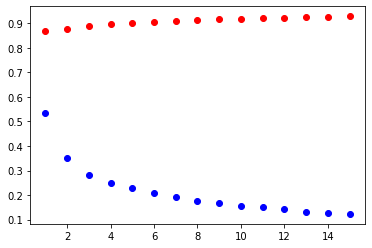

======================= Trial: 9026 =======================

Train loss at epoch 1:  0.5685748
Train Acc at epoch 1:  0.863593
Eval loss at epoch 1:  0.57927245
Eval Acc at epoch 1:  0.8647793

Train loss at epoch 2:  0.3641266
Train Acc at epoch 2:  0.8725318
Eval loss at epoch 2:  0.38279057
Eval Acc at epoch 2:  0.878631

Train loss at epoch 3:  0.29999363
Train Acc at epoch 3:  0.8835736
Eval loss at epoch 3:  0.32761073
Eval Acc at epoch 3:  0.88753444

Train loss at epoch 4:  0.2615566
Train Acc at epoch 4:  0.8907722
Eval loss at epoch 4:  0.29606614
Eval Acc at epoch 4:  0.8938863

Train loss at epoch 5:  0.23747754
Train Acc at epoch 5:  0.8965374
Eval loss at epoch 5:  0.27934808
Eval Acc at epoch 5:  0.8991688

Train loss at epoch 6:  0.2181885
Train Acc at epoch 6:  0.90136963
Eval loss at epoch 6:  0.26904455
Eval Acc at epoch 6:  0.90356725

Train loss at epoch 7:  0.2000241
Train Acc at epoch 7:  0.9054833
Eval loss at epoch 7:  0.2571021
Eval Acc at epoch 7:  0.9074034


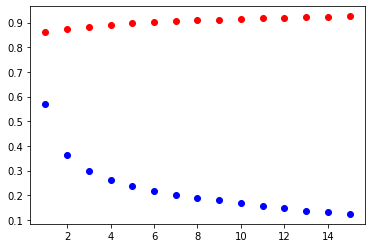

======================= Trial: 4818 =======================

Train loss at epoch 1:  0.5159182
Train Acc at epoch 1:  0.87335026
Eval loss at epoch 1:  0.5269118
Eval Acc at epoch 1:  0.8745851

Train loss at epoch 2:  0.3427884
Train Acc at epoch 2:  0.8809464
Eval loss at epoch 2:  0.36136654
Eval Acc at epoch 2:  0.8866946

Train loss at epoch 3:  0.28217304
Train Acc at epoch 3:  0.8910055
Eval loss at epoch 3:  0.30929753
Eval Acc at epoch 3:  0.89491105

Train loss at epoch 4:  0.2526501
Train Acc at epoch 4:  0.89778155
Eval loss at epoch 4:  0.28537133
Eval Acc at epoch 4:  0.90060484

Train loss at epoch 5:  0.2259718
Train Acc at epoch 5:  0.90298784
Eval loss at epoch 5:  0.26686156
Eval Acc at epoch 5:  0.9053644

Train loss at epoch 6:  0.21133043
Train Acc at epoch 6:  0.90719986
Eval loss at epoch 6:  0.26017374
Eval Acc at epoch 6:  0.9091063

Train loss at epoch 7:  0.19776125
Train Acc at epoch 7:  0.91065884
Eval loss at epoch 7:  0.2541761
Eval Acc at epoch 7:  0.91

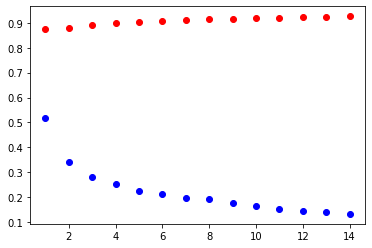

the mean of 3 runs is 0.9278035163879395, and the variance is 1.64133632551966e-06


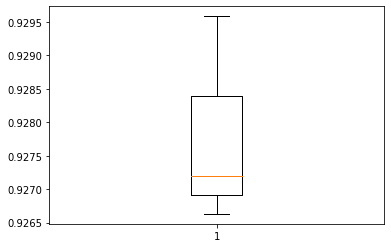

In [ ]:
# Train and Test model

seeds = np.random.randint(1000,9999,3)
test_accuracy = []

for i in seeds:
  # Instantiate model. This doesn't initialize the variables yet.
  model = ImageRecognitionCNN(num_classes=10, device=device, 
                                checkpoint_directory=checkpoint_directory)
  print('======================= Trial:', i, '=======================')
  model.fit_fc(train_dataset, val_dataset, optimizer, num_epochs=20, 
            early_stopping_rounds=2, verbose=1, train_from_scratch=True)
  
  accuracy = model.compute_accuracy_2(x_test,y_test)
  test_accuracy.append(accuracy)

  
test_mean = np.mean(test_accuracy)
test_var = np.var(test_accuracy)

print(f"the mean of 3 runs is {test_mean}, and the variance is {test_var}")
plt.boxplot(test_accuracy)
plt.show()
